## Set Folders

In [178]:
import mediapipe as mp 
import cv2 #opencv
import math #basic operations
import numpy as np #basic operations
import pandas as pd #data wrangling
import csv #csv saving
import os #some basic functions for inspecting folder structure etc.

#list all videos in input_videofolder
from os import listdir
from os.path import isfile, join
mypath = "/Users/onurkeles/Desktop/Python Projects/Thesis - Mediapipe/RE/Input_Videos" 
vfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
#time series output folder
inputfol = "/Users/onurkeles/Desktop/Python Projects/Thesis - Mediapipe/RE/Input_Videos/"
outtputf_ts = "/Users/onurkeles/Desktop/Python Projects/Thesis - Mediapipe/RE/Output_TimeSeries"

#check videos to be processed
print("The following folder is set as the output folder where all the pose time series are stored")
print(os.path.abspath(outtputf_ts))
print("\n The following video(s) will be processed for masking: ")
print(vfiles)


The following folder is set as the output folder where all the pose time series are stored
/Users/onurkeles/Desktop/Python Projects/Thesis - Mediapipe/RE/Output_TimeSeries

 The following video(s) will be processed for masking: 
['Participant_33_Narrative_3_FARE_Re-introduction_Order10.mp4', 'Participant_22_Narrative_10_KEDİ_Re-introduction_Order7.mp4', 'Participant_10_Narrative_9_FARE_Re-introduction_Order7.mp4', 'Participant_26_Narrative_4_KEDİ_Introduction_Order9.mp4', 'Participant_18_Narrative_5_FARE_Introduction_Order2.mp4', 'Participant_15_Narrative_10_KEDİ_Re-introduction_Order11.mp4', 'Participant_28_Narrative_1_FARE_Introduction_Order5.mp4', 'Participant_25_Narrative_6_FARE_Re-introduction_Order16.mp4', 'Participant_19_Narrative_1_KEDİ_Re-introduction_Order12.mp4', 'Participant_33_Narrative_1_KEDİ_Re-introduction_Order5.mp4', 'Participant_29_Narrative_1_KEDİ_Introduction_Order3.mp4', 'Participant_33_Narrative_5_FARE_Re-introduction_Order9.mp4', 'Participant_32_Narrative_

## Initialize Mediapipe modules and functions

In [ ]:
#initialize modules and functions

#load in mediapipe modules
mp_holistic = mp.solutions.holistic
# Import drawing_utils and drawing_styles.
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

##################FUNCTIONS AND OTHER VARIABLES
#landmarks 33x that are used by Mediapipe
markersbody = ['NOSE', 'LEFT_EYE_INNER', 'LEFT_EYE', 'LEFT_EYE_OUTER', 'RIGHT_EYE_OUTER', 'RIGHT_EYE', 'RIGHT_EYE_OUTER',
          'LEFT_EAR', 'RIGHT_EAR', 'MOUTH_LEFT', 'MOUTH_RIGHT', 'LEFT_SHOULDER', 'RIGHT_SHOULDER', 'LEFT_ELBOW', 
          'RIGHT_ELBOW', 'LEFT_WRIST', 'RIGHT_WRIST', 'LEFT_PINKY', 'RIGHT_PINKY', 'LEFT_INDEX', 'RIGHT_INDEX',
          'LEFT_THUMB', 'RIGHT_THUMB', 'LEFT_HIP', 'RIGHT_HIP', 'LEFT_KNEE', 'RIGHT_KNEE', 'LEFT_ANKLE', 'RIGHT_ANKLE',
          'LEFT_HEEL', 'RIGHT_HEEL', 'LEFT_FOOT_INDEX', 'RIGHT_FOOT_INDEX']


print("Note that we have the following number of pose keypoints for markers body")
print(len(markersbody))

#set up the column names and objects for the time series data 
markerxyzbody = ['Time']

for mark in markersbody:
    for pos in ['X', 'Y', 'Z', 'visibility']: #for markers of the body 
        nm = pos + "_" + mark
        markerxyzbody.append(nm)

def num_there(s):
    return any(i.isdigit() for i in s)

def makegoginto_str(gogobj):
    gogobj = str(gogobj).strip("[]")
    gogobj = gogobj.split("\n")
    return(gogobj[:-1]) #ignore last element as this has nothing

def listpostions(newsamplemarks):
    newsamplemarks = makegoginto_str(newsamplemarks)
    tracking_p = []
    for value in newsamplemarks:
        if num_there(value):
            stripped = value.split(':', 1)[1]
            stripped = stripped.strip() #remove spaces in the string if present
            tracking_p.append(stripped) #add to this list  
    return(tracking_p)

Note that we have the following number of pose keypoints for markers body
33


## Getting joint coordinates

In [ ]:
import csv

output_csv = '/Users/onurkeles/Desktop/Python Projects/Thesis - Mediapipe/RE/Output_TimeSeries/raw_data.csv'

with open(output_csv, 'w', newline='') as file:
    pass

for vidf in vfiles:
    #print("We will now process video:")
    #print(vidf)
    print("This is video number" + str(vfiles.index(vidf))+ "of" + str(len(vfiles)) + "videos in total")

    if not vidf.endswith('.mp4'):
        #print(f"Skipping non-mp4 file: {vidf}")
        continue  # Skip the rest of the loop for this iteration
    
    base_name = os.path.basename(vidf).replace('.mp4', '')  # Get the filename without the path and remove extension
    
    # Handle the space issue by replacing spaces with underscores temporarily
    base_name = base_name.replace(' ', '_')
    
    parts = base_name.split('_')  # Split by underscore
    
    if len(parts) < 6:
        print(f"Skipping file '{vidf}' due to incorrect format.")
    
    participant = parts[1]
    narrative = parts[3]  # Directly extract narrative part
    re = parts[4]
    discourse = parts[5]  # Directly extract discourse part
    order = parts[6]


    #capture the video, and check video settings
    videoname = vidf
    videoloc = inputfol + videoname
    capture = cv2.VideoCapture(videoloc) #load in the videocapture
    frameWidth = capture.get(cv2.CAP_PROP_FRAME_WIDTH) #check frame width
    frameHeight = capture.get(cv2.CAP_PROP_FRAME_HEIGHT) #check frame height
    samplerate = capture.get(cv2.CAP_PROP_FPS) 
    time_increment = 1000 / 50
    time = 0  # Initialize time
    frame_idx = 0
    non_detected_frames = 0    

    total_frames = capture.get(cv2.CAP_PROP_FRAME_COUNT)  # total number of frames in the video
    if samplerate > 0:
        duration = total_frames / samplerate
        #print(f"Video: {videoname}, FPS: {samplerate}, Resolution: ({int(frameWidth)}, {int(frameHeight)}), Duration: {duration:.2f} seconds, Total Frames: {total_frames}")
    else:
        #print(f"Video: {videoname}, FPS: Not available, Resolution: ({int(frameWidth)}, {int(frameHeight)}), Duration: Cannot calculate duration with undefined FPS")

        samplerate = capture.get(cv2.CAP_PROP_FPS)   #fps = frames per second

  
    tsbody = [markerxyzbody]   

    with mp.solutions.holistic.Holistic(static_image_mode=False, enable_segmentation=True, model_complexity=1, smooth_landmarks=True, min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while True:
            ret, image = capture.read()  # read frame
            if not ret:  # if there is no frame, break the loop
                #print(f"Frame {frame_idx} not found")
                break
            
            image.flags.writeable = False
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB once
            results = holistic.process(image_rgb)  # Apply Mediapipe holistic processing
            frame_idx = frame_idx + 1
            time += time_increment


            results = holistic.process(image)

            if results.pose_landmarks:  # Check if there is a pose found
                #print(f"Landmarks detected in frame {frame_idx}")
                original_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)  # Convert back to BGR for visualization
                mp_drawing.draw_landmarks(
                    original_image,
                    results.pose_landmarks,
                    mp.solutions.holistic.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

                # Now save everything to a time series
                samplebody = listpostions(results.pose_landmarks)
                samplebody.insert(0, time)  # Insert time at the beginning of the data row
                tsbody.append(samplebody)  # Append to the timeseries object

            else:
                non_detected_frames += 1
                print(f"No landmarks detected in frame {frame_idx}")
                #original_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
                # Add empty row of DATA NA
                samplebody = [np.nan for x in range(len(markerxyzbody) - 1)]
                samplebody.insert(0, time)
                tsbody.append(samplebody)  # Append to the timeseries object


            if cv2.waitKey(1) == 27:  # allow the use of ESCAPE to break the loop
                break
            if ret == False:  # if there are no more frames, break the loop
                break

    # Output summary of processing
    #print(f"Total frames processed: {frame_idx}")
    #print(f"Total time: {time} ms")
    #print(f"Frames without detected landmarks: {non_detected_frames}")
    
    # Define the columns you want to keep
    columns_to_keep = ['Time',
                    'X_LEFT_WRIST', 'Y_LEFT_WRIST', 'Z_LEFT_WRIST', 'visibility_LEFT_WRIST',
                    'X_RIGHT_WRIST', 'Y_RIGHT_WRIST', 'Z_RIGHT_WRIST', 'visibility_RIGHT_WRIST',
                    'X_LEFT_SHOULDER', 'Y_LEFT_SHOULDER', 'Z_LEFT_SHOULDER', 'visibility_LEFT_SHOULDER',
                    'X_RIGHT_SHOULDER', 'Y_RIGHT_SHOULDER', 'Z_RIGHT_SHOULDER', 'visibility_RIGHT_SHOULDER',
                    'X_LEFT_ELBOW', 'Y_LEFT_ELBOW', 'Z_LEFT_ELBOW', 'visibility_LEFT_ELBOW',
                    'X_RIGHT_ELBOW', 'Y_RIGHT_ELBOW', 'Z_RIGHT_ELBOW', 'visibility_RIGHT_ELBOW',
                    'X_LEFT_PINKY', 'Y_LEFT_PINKY', 'Z_LEFT_PINKY', 'visibility_LEFT_PINKY',
                    'X_LEFT_THUMB', 'Y_LEFT_THUMB', 'Z_LEFT_THUMB', 'visibility_LEFT_THUMB',
                    'X_RIGHT_PINKY', 'Y_RIGHT_PINKY', 'Z_RIGHT_PINKY', 'visibility_RIGHT_PINKY',
                    'X_RIGHT_THUMB', 'Y_RIGHT_THUMB', 'Z_RIGHT_THUMB', 'visibility_RIGHT_THUMB']

    # once done de-initialize all processes
    capture.release()
    cv2.destroyAllWindows()

    # Check if the output CSV already has data
    file_exists = os.path.exists(output_csv) and os.path.getsize(output_csv) > 0
    
    with open(output_csv, 'a', newline='') as file:
        write = csv.writer(file)
    # Write filtered data rows
        for i, row in enumerate(tsbody):
            if i == 0:
                if not file_exists:
                    filtered_headers = ["Participant", "Narrative", "RE", "Discourse","Order"]+ columns_to_keep
                    write.writerow(filtered_headers)
            else:
                filtered_row = [participant, narrative, re, discourse, order] + [row[0]]+ [row[i+1] for i in range(len(markerxyzbody) - 1) if markerxyzbody[i+1] in columns_to_keep]
                write.writerow(filtered_row)

# Read the CSV file into a DataFrame
df = pd.read_csv(output_csv)

# Sort the DataFrame by 'Participant', 'Narrative', and 'Event' columns
df.sort_values(by=['Participant', 'Narrative', 'RE', 'Discourse','Order'], inplace=True)

# Save the sorted and filtered DataFrame back to the CSV file
df.to_csv(output_csv, index=False)

print("CSV file sorted.")

## Median and Visibility Filtering

In [ ]:
import pandas as pd

# Apply median filter to the data
df_filtered = pd.read_csv("/Users/onurkeles/Desktop/Python Projects/Thesis - Mediapipe/RE/Output_TimeSeries/raw_data.csv")

columns_to_exclude = ['Participant', 'Narrative', 'RE', 'Discourse','Order','Time']

columns_to_filter = df_filtered.columns.difference(columns_to_exclude)

#df_filtered.iloc[0, columns_to_filter] = df.iloc[0, columns_to_filter]

df_filtered.loc[1:, columns_to_filter] = df.loc[1:, columns_to_filter].rolling(window=5, min_periods=1).median()

visibility_columns = df_filtered.columns[df_filtered.columns.str.contains('visibility')]

df_filtered = df_filtered[(df_filtered[visibility_columns] >= 0.90).all(axis=1)]

# Save the filtered data
df_filtered.to_csv('/Users/onurkeles/Desktop/Python Projects/Thesis - Mediapipe/RE/Output_TimeSeries/df_filtered.csv', index=False)

        

## Body Normalization

In [ ]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('/Users/onurkeles/Desktop/Python Projects/Thesis - Mediapipe/RE/Output_TimeSeries/df_filtered.csv')
#df = df[(df[visibility_columns] >= 0.80).all(axis=1)]

# Calculate the upper arm length for each frame
df['upper_arm_length_right'] = np.sqrt(
    (df['X_RIGHT_SHOULDER'] - df['X_RIGHT_ELBOW']) ** 2 +
    (df['Y_RIGHT_SHOULDER'] - df['Y_RIGHT_ELBOW']) ** 2 +
    (df['Z_RIGHT_SHOULDER'] - df['Z_RIGHT_ELBOW']) ** 2
)

df['upper_arm_length_left'] = np.sqrt(
    (df['X_LEFT_SHOULDER'] - df['X_LEFT_ELBOW']) ** 2 +
    (df['Y_LEFT_SHOULDER'] - df['Y_LEFT_ELBOW']) ** 2 +
    (df['Z_LEFT_SHOULDER'] - df['Z_LEFT_ELBOW']) ** 2
)

# Calculate the mean upper arm length for each participant and store them
mean_upper_arm_length_per_participant = df.groupby('Participant')[['upper_arm_length_right', 'upper_arm_length_left']].mean().mean(axis=1).to_dict()

# Calculate the average upper arm length across all participants
average_upper_arm_length_all = np.mean(list(mean_upper_arm_length_per_participant.values()))

# Normalize the data based on the scaling factor
df['scaling_factor'] = df['Participant'].map(mean_upper_arm_length_per_participant) / average_upper_arm_length_all

# Select columns to apply scaling, excluding identifiers and non-scale columns

visibility_columns = df.columns[df.columns.str.contains('visibility')]

scale_columns = df.select_dtypes(include=[np.number]).columns.difference(
    ['Participant', 'Narrative', 'RE', 'Discourse','Order', 'Time', 'upper_arm_length_right', 'upper_arm_length_left','scaling_factor']).difference(visibility_columns)


# Apply the scaling factor to relevant data points
df[scale_columns] = df[scale_columns].div(df['scaling_factor'], axis=0)

# Save the transformed data
output_path = '/Users/onurkeles/Desktop/Python Projects/Thesis - Mediapipe/RE/Output_TimeSeries/df_transformed.csv'
df.to_csv(output_path, index=False)

print(f"Transformed data saved to {output_path}")


Transformed data saved to /Users/onurkeles/Desktop/Python Projects/Thesis - Mediapipe/RE/Output_TimeSeries/df_transformed.csv


## RE Duration Calculation

In [105]:
df = pd.read_csv('/Users/onurkeles/Desktop/Python Projects/Thesis - Mediapipe/RE/Output_TimeSeries/df_transformed.csv')

# Calculate the duration for each participant and each event
re_durations = df.groupby(['Participant', 'Narrative','RE','Order','Discourse'])['Time'].max() 

# Convert durations to seconds
re_durations = re_durations / 1000

# Reset the index to merge back with the original dataframe
re_durations = re_durations.reset_index()
re_durations = re_durations.rename(columns={'Time': 'Duration'})

# Merge the re durations back into the original dataframe
df = pd.merge(df, re_durations, on=['Participant', 'Narrative','RE','Order','Discourse'], how='left')

duration_sum = df.groupby(["Discourse"])['Duration'].mean()
print(duration_sum)


df.to_csv('/Users/onurkeles/Desktop/Python Projects/Thesis - Mediapipe/RE/Output_TimeSeries/df_transformed.csv', index=False)


Discourse
Introduction       0.779491
Maintenance        0.483597
Re-introduction    0.466632
Name: Duration, dtype: float64


## Hand Movement Amplitude Calculation

In [ ]:

df_filtered = pd.read_csv('/Users/onurkeles/Desktop/Python Projects/Thesis - Mediapipe/RE/Output_TimeSeries/df_transformed.csv')

df_filtered['X_RIGHT_HAND'] = (df_filtered['X_RIGHT_THUMB'] + df_filtered['X_RIGHT_PINKY']) / 2
df_filtered['Y_RIGHT_HAND'] = (df_filtered['Y_RIGHT_THUMB'] + df_filtered['Y_RIGHT_PINKY']) / 2
df_filtered['Z_RIGHT_HAND'] = (df_filtered['Z_RIGHT_THUMB'] + df_filtered['Z_RIGHT_PINKY']) / 2

df_filtered['X_LEFT_HAND'] = (df_filtered['X_LEFT_THUMB'] + df_filtered['X_LEFT_PINKY']) / 2
df_filtered['Y_LEFT_HAND'] = (df_filtered['Y_LEFT_THUMB'] + df_filtered['Y_LEFT_PINKY']) / 2
df_filtered['Z_LEFT_HAND'] = (df_filtered['Z_LEFT_THUMB'] + df_filtered['Z_LEFT_PINKY']) / 2

# Calculate the Euclidean distance between hand positions for the right hand
df_filtered['Right_Hand_Movement_Amplitude'] = np.sqrt(
    (df_filtered['X_RIGHT_HAND'].diff())**2 +
    (df_filtered['Y_RIGHT_HAND'].diff())**2 +
    (df_filtered['Z_RIGHT_HAND'].diff())**2
)

# Calculate the Euclidean distance between hand positions for the left hand
df_filtered['Left_Hand_Movement_Amplitude'] = np.sqrt(
    (df_filtered['X_LEFT_HAND'].diff())**2 +
    (df_filtered['Y_LEFT_HAND'].diff())**2 +
    (df_filtered['Z_LEFT_HAND'].diff())**2
)

    # Save the data
df_filtered.to_csv('/Users/onurkeles/Desktop/Python Projects/Thesis - Mediapipe/RE/Output_TimeSeries/df_output.csv', index=False)



## Sign Space Calculation

In [ ]:
# calculate distance between the wrists and middle of shoulders:

import numpy as np

#for csv_file in csv_files:
    # Load the data
df_filtered = pd.read_csv('/Users/onurkeles/Desktop/Python Projects/Thesis - Mediapipe/RE/Output_TimeSeries/df_output.csv')

df_filtered['X_MID_SHOULDER'] = (df_filtered['X_LEFT_SHOULDER'] + df_filtered['X_RIGHT_SHOULDER']) / 2
df_filtered['Y_MID_SHOULDER'] = (df_filtered['Y_LEFT_SHOULDER'] + df_filtered['Y_RIGHT_SHOULDER']) / 2
df_filtered['Z_MID_SHOULDER'] = (df_filtered['Z_LEFT_SHOULDER'] + df_filtered['Z_RIGHT_SHOULDER']) / 2

df_filtered['Left_S_to_W_Distance'] = np.sqrt((df_filtered['X_LEFT_WRIST'] - df_filtered['X_MID_SHOULDER'])**2 +
                                                    (df_filtered['Y_LEFT_WRIST'] - df_filtered['Y_MID_SHOULDER'])**2 +
                                                    (df_filtered['Z_LEFT_WRIST'] - df_filtered['Z_MID_SHOULDER'])**2)
    
df_filtered['Right_S_to_W_Distance'] = np.sqrt((df_filtered['X_RIGHT_WRIST'] - df_filtered['X_MID_SHOULDER'])**2 +
                                                    (df_filtered['Y_RIGHT_WRIST'] - df_filtered['Y_MID_SHOULDER'])**2 +
                                                    (df_filtered['Z_RIGHT_WRIST'] - df_filtered['Z_MID_SHOULDER'])**2)
    
# Calculate the frame-by-frame difference in Mean_S_to_W_Distance
df_filtered['Left_S_to_W_Distance_Change'] = np.abs(df_filtered['Left_S_to_W_Distance'].diff())
df_filtered['Right_S_to_W_Distance_Change'] = np.abs(df_filtered['Right_S_to_W_Distance'].diff())

total_s_to_w_distance_change = df_filtered.groupby(["Discourse"])['Right_S_to_W_Distance'].mean()


    # Save the data
df_filtered.to_csv('/Users/onurkeles/Desktop/Python Projects/Thesis - Mediapipe/RE/Output_TimeSeries/df_output.csv', index=False)



## Dataset Cleaning

In [108]:
import pandas as pd

# Load the datasets
df1 = pd.read_csv('/Users/onurkeles/Desktop/Python Projects/Thesis - Mediapipe/RE/Output_TimeSeries/df_output.csv')
df2 = pd.read_csv('/Users/onurkeles/Desktop/Python Projects/Thesis - Mediapipe/Accessibility Ratings/accessibility_scores_updated.csv')

# Rename and map necessary columns in df2 to align with df1
df2.rename(columns={
    'Subject': 'Participant',
    'Reference': 'Order',
}, inplace=True)

# Convert 'Order' in df1 from 'Order1', 'Order2', ... to numeric
df1['Order'] = df1['Order'].str.extract('(\d+)').astype(int)

# Merge df1 with df2 on the keys without matching on 'RE'
merged_df = pd.merge(df1, df2[['Participant', 'Narrative', 'Discourse', 'Order', 'Accessibility']],
                     on=['Participant', 'Narrative', 'Discourse', 'Order'], 
                     how='left')

# Participant to nativeness mapping
participant_nativeness = {
    2: 1, 3: 1, 4: 0, 10: 0, 12: 0, 13: 1, 14: 1, 15: 0, 16: 0, 18: 1,
    19: 0, 20: 1, 21: 0, 22: 1, 23: 0, 24: 1, 25: 0, 26: 1, 27: 1, 28: 0,
    29: 1, 30: 1, 31: 0, 32: 0, 33: 1, 34: 1, 35: 0, 36: 0, 38: 1
}


# Map nativeness codes to descriptive labels
nativeness_labels = {1: "Native", 0: "Late"}

merged_df['Nativeness'] = merged_df['Participant'].map(participant_nativeness).map(nativeness_labels)

year_of_exposure = {
    2: "0-3", 3: "0-3", 4: "4-7", 10: "13-17", 12: "8-12", 13: "0-3", 14: "0-3", 15: "8-12", 16: "4-7", 18: "0-3",
    19: "8-12", 20: "0-3", 21: "4-7", 22: "0-3", 23: "13-17", 24: "0-3", 25: "4-7", 26: "0-3", 27: "0-3", 28: "8-12",
    29: "0-3", 30: "0-3", 31: "8-12", 32: "8-12", 33: "0-3", 34: "0-3", 35: "4-7", 36: "4-7", 38: "0-3"
}

# Apply the mapping to the DataFrame
merged_df['Exposure'] = merged_df['Participant'].map(year_of_exposure)

na_count = merged_df['Accessibility'].isna().sum()
print("Number of missing 'Accessibility' values:", na_count)

cleaned_df = merged_df.dropna(subset=['Accessibility'])

# Save the merged DataFrame if necessary
cleaned_df.to_csv('/Users/onurkeles/Desktop/Python Projects/Thesis - Mediapipe/RE/Output_TimeSeries/merged_output.csv', index=False)



Number of missing 'Accessibility' values: 55


In [ ]:
import pandas as pd

# Load the DataFrame
df = pd.read_csv('/Users/onurkeles/Desktop/Python Projects/Thesis - Mediapipe/RE/Output_TimeSeries/merged_output.csv')


# Group by multiple columns and calculate various statistics
summary_table = df.groupby(['Participant', 'Narrative', 'RE', 'Discourse', 'Order', 'Accessibility']).agg({
    'Right_Hand_Movement_Amplitude': 'sum',
    'Left_Hand_Movement_Amplitude': 'sum',
    'Left_S_to_W_Distance_Change':'sum',
    'Right_S_to_W_Distance_Change':'sum',
    'Duration': 'mean'
}).reset_index()

# Save the summary table
summary_table.to_csv('/Users/onurkeles/Desktop/Python Projects/Thesis - Mediapipe/RE/Output_TimeSeries/df_results2.csv')


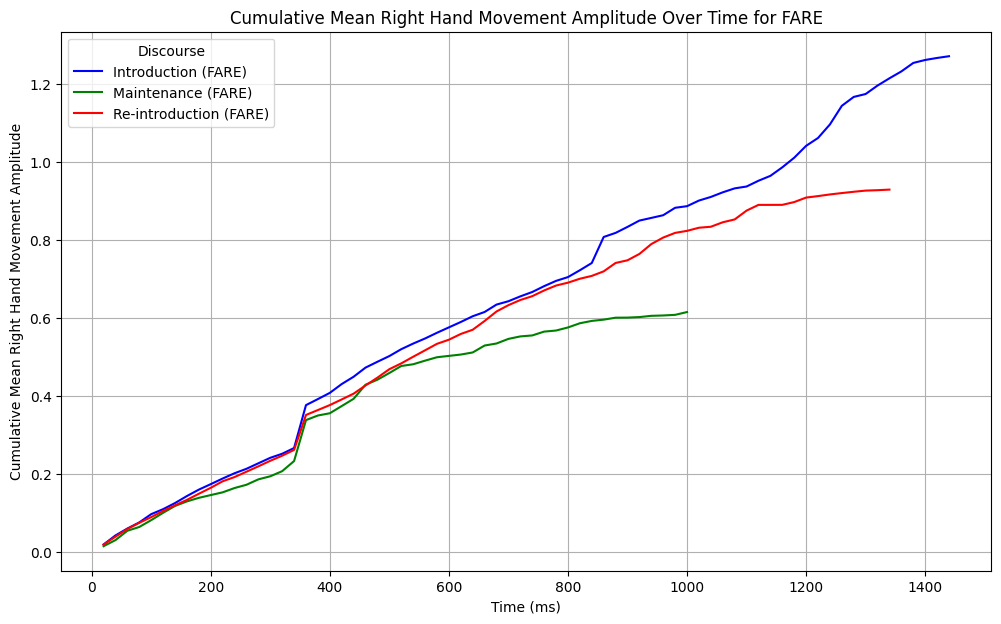

In [ ]:
# Example plot
import pandas as pd
import matplotlib.pyplot as plt

# Load the DataFrame
df = pd.read_csv('/Users/onurkeles/Desktop/Python Projects/Thesis - Mediapipe/RE/Output_TimeSeries/df_results.csv')

def plot_cumulative_mean_speed_by_re_discourse(re):
    # Define discourse types
    discourses = ["Introduction", "Maintenance", "Re-introduction"]
    colors = {'Introduction': 'blue', 'Maintenance': 'green', 'Re-introduction': 'red'}  # Color coding for clarity

    plt.figure(figsize=(12, 7))
    
    # Iterate over each discourse
    for discourse in discourses:
        subset = df[(df['RE'] == re) & (df['Discourse'] == discourse)]
        subset = subset[subset['Duration'] < 1.5]
        
        # Group by time intervals (could be every 50 ms, 100 ms, etc., based on data frequency)
        subset['Time Interval'] = (subset['Time'] // 1) * 1
        averaged_speed = subset.groupby('Time Interval')['Right_Hand_Movement_Amplitude'].mean().reset_index()
        
        # Calculate the cumulative sum of the averaged speeds
        averaged_speed['Cumulative Movement Amplitude'] = averaged_speed['Right_Hand_Movement_Amplitude'].cumsum()

        # Plotting the cumulative movement amplitude over time
        plt.plot(averaged_speed['Time Interval'], averaged_speed['Cumulative Movement Amplitude'], label=f'{discourse} ({re})', color=colors[discourse])

    plt.title(f'Cumulative Mean Right Hand Movement Amplitude Over Time for {re}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Cumulative Mean Right Hand Movement Amplitude')
    plt.legend(title='Discourse')
    plt.grid(True)
    plt.show()

# Example usage:
re_input = "FARE"
plot_cumulative_mean_speed_by_re_discourse(re_input)
